In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import numpy as np
import random

import torch
import torchvision
import torchvision.transforms as T

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [4]:
CATEGORIES_IDX = [1, 73]
CATEGORIES = ["person", "laptop"]

In [5]:
def get_prediction(img_path, threshold=0.8):
    img = T.Compose([T.ToTensor()])(Image.open(img_path))
    pred = model([img.to(device)])
    pred_score = list(pred[0]["scores"].cpu().detach().numpy())
    labels = list(pred[0]["labels"].cpu().detach().numpy())
    boxes = list(pred[0]["boxes"].cpu().detach().numpy())

    # pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]

    # masks = (pred[0]['masks'] > threshold).squeeze().detach().cpu().numpy()
    # masks = masks[:pred_t + 1]
    # print(masks)
    masks = list(pred[0]["masks"].squeeze().detach().cpu().numpy())

    pred_class = []
    pred_boxes = []
    pred_masks = []
    for i, (label, box, mask) in enumerate(zip(labels, boxes, masks)):
        if pred_score[i] > threshold and label in CATEGORIES_IDX:
            pred_class.append(CATEGORIES[CATEGORIES_IDX.index(label)])
            pred_boxes.append([(box[0], box[1]), (box[2], box[3])])
            pred_masks.append(mask > threshold)
    return pred_boxes, pred_class, pred_score, pred_masks

In [6]:
def random_colour_masks(image):
    colours = [[0, 255, 0], [0, 0, 255], [255, 0, 0], [0, 255, 255], [255, 255, 0], [255, 0, 255], [80, 70, 180],
               [250, 80, 190], [245, 145, 50], [70, 150, 250], [50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0, 10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [7]:
def detect_object_on_image(img_path):
    boxes, classes, scores, masks = get_prediction(img_path)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    for cls, box, score, mask in zip(classes, boxes, scores, masks):
        rgb_mask = random_colour_masks(mask)
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        main_color = (0, 0, 255)
        if cls == 'laptop':
            main_color = (255, 0, 0)
        cv2.rectangle(img, box[0], box[1], color=main_color, thickness=2)
        cv2.putText(img, cls + " " + str(score), box[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, main_color, thickness=1)

    plt.figure(figsize=(20, 30))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

<ipython-input-7-c7875f566524>:11: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(img, box[0], box[1], color=main_color, thickness=2)
<ipython-input-7-c7875f566524>:12: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.putText(img, cls + " " + str(score), box[0], cv2.FONT_HERSHEY_SIMPLEX, 0.5, main_color, thickness=1)


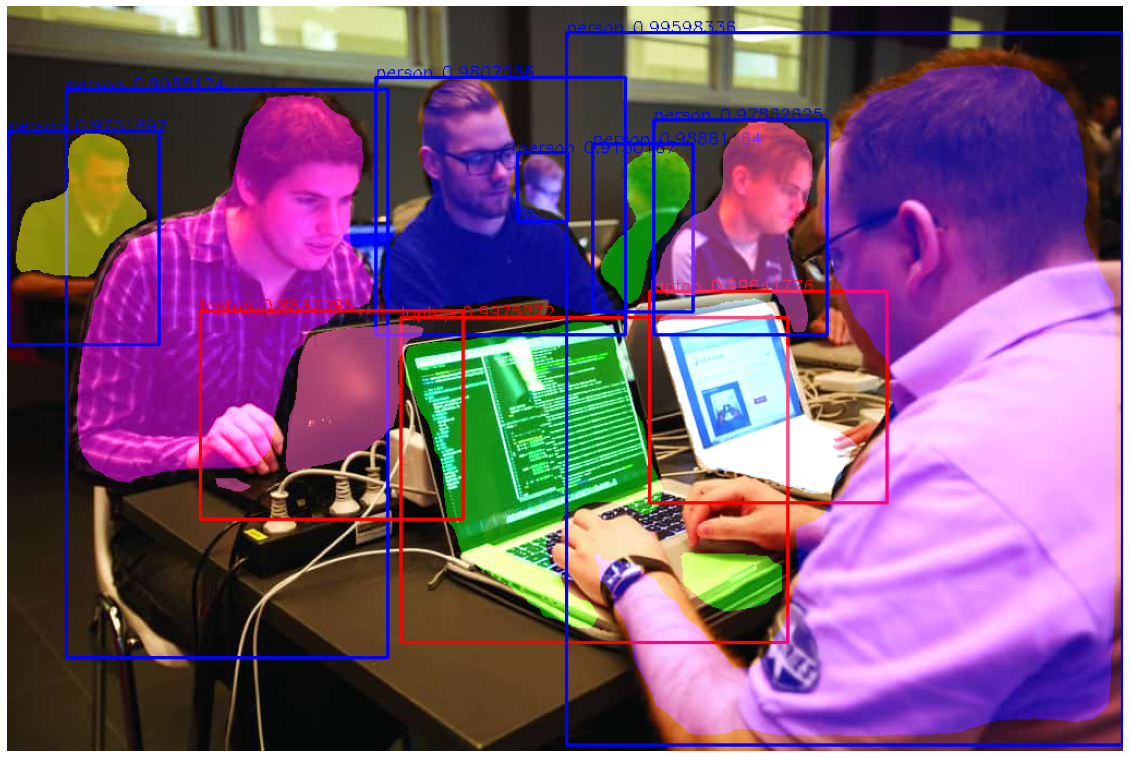

In [8]:
detect_object_on_image(r"samples/sample10.jpg")

In [18]:
import socket